In [1]:
%load_ext lab_black

In [21]:
import os
from typing import Tuple, List, Sequence, Callable

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import imageio
import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
df = pd.read_csv("../data/ori/train_df.csv")
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


## 1. 데이터셋 전처리 및 시각화

In [25]:
def draw_keypoints(
    image: np.ndarray, keypoints: np.ndarray, edges: List[Tuple[int, int]]
) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))):
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}
    x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
    x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, tuple(keypoint), 3, colors.get(i), thickness=3, lineType=cv2.FILLED
        )

        cv2.putText(
            image,
            f"{i}: {keypoint_names[i]}",
            tuple(keypoint),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 0),
            1,
        )

    for i, edge in enumerate(edges):
        cv2.line(
            image,
            tuple(keypoints[edge[0]]),
            tuple(keypoints[edge[1]]),
            colors.get(edge[0]),
            3,
            lineType=cv2.LINE_AA,
        )

    plt.figure(figsize=(16, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig("example.png")
    imageio.imwrite("example.png", image)
    plt.show()

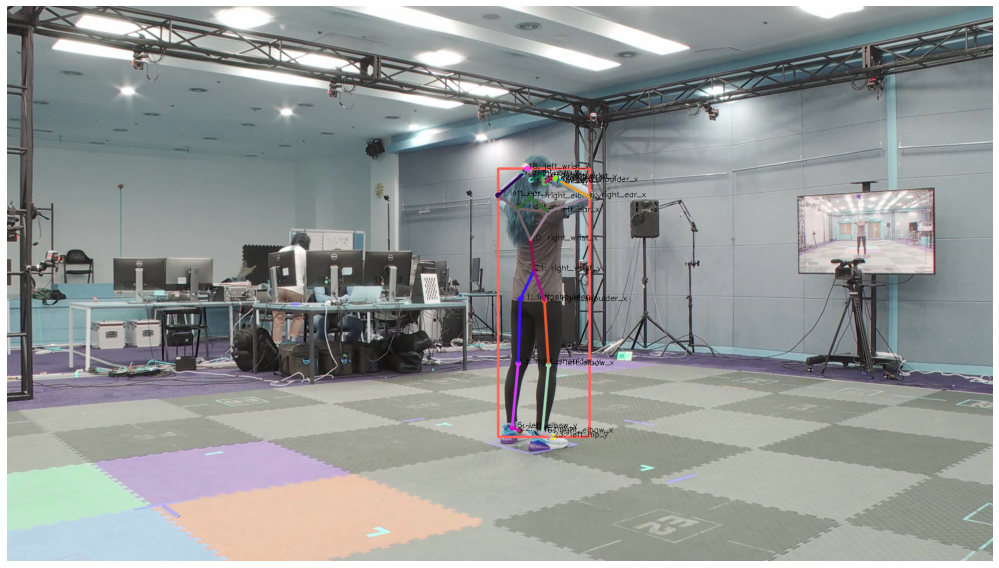

In [26]:
keypoints = df.iloc[0, 1:].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = df.columns[1:].tolist()

edges = [
    (0, 1),
    (0, 2),
    (2, 4),
    (1, 3),
    (6, 8),
    (8, 10),
    (5, 7),
    (7, 9),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16),
    (5, 6),
    (15, 22),
    (16, 23),
    (11, 21),
    (21, 12),
    (20, 21),
    (5, 20),
    (6, 20),
    (17, 6),
    (17, 5),
]

image = cv2.imread(
    "../data/ori/train_imgs/001-1-1-01-Z17_A-0000001.jpg", cv2.COLOR_BGR2RGB
)
draw_keypoints(image, keypoints, edges)

## 2. torchvision 모형을 이용한 추론

In [27]:
image = cv2.imread(
    "../data/ori/train_imgs/001-1-1-01-Z17_A-0000001.jpg", cv2.COLOR_BGR2RGB
)
image = cv2.resize(image, (1333, 800))
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = keypointrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()
preds = model(image)
preds[0].keys()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /home/s0/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

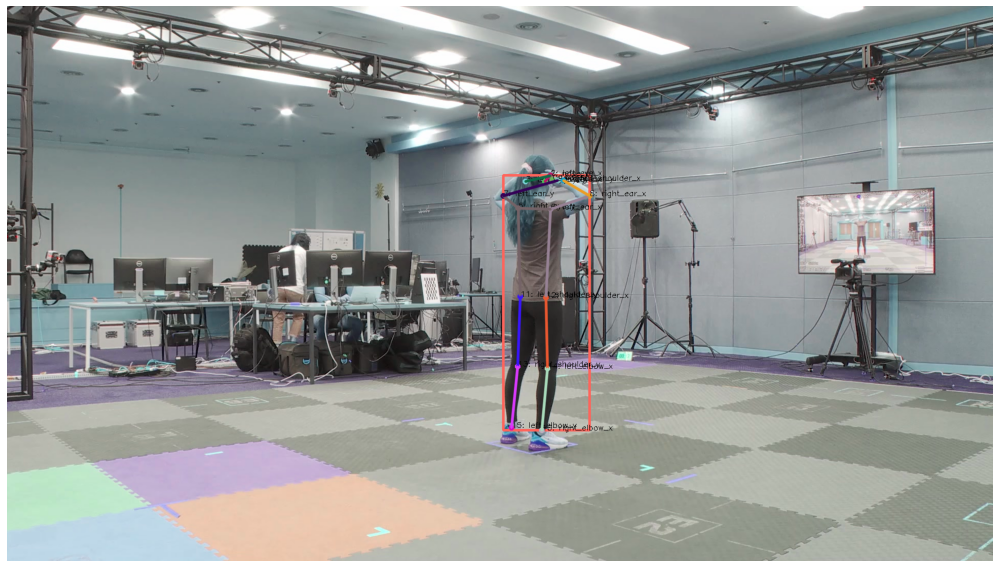

In [29]:
keypoints = preds[0]["keypoints"].detach().numpy().copy()[0]
image = cv2.imread(
    "../data/ori/train_imgs/001-1-1-01-Z17_A-0000001.jpg", cv2.COLOR_BGR2RGB
)
keypoints[:, 0] *= image.shape[1] / 1333
keypoints[:, 1] *= image.shape[0] / 800
keypoints = keypoints[:, :2]

edges = [
    (0, 1),
    (0, 2),
    (2, 4),
    (1, 3),
    (6, 8),
    (8, 10),
    (5, 7),
    (7, 9),
    (5, 11),
    (11, 13),
    (13, 15),
    (6, 12),
    (12, 14),
    (14, 16),
    (5, 6),
]

draw_keypoints(image, keypoints, edges)

## 3. Keypoint R-CNN 학습하기

`torchvision`의 `Keypoint R-CNN`을 사용하실려면, 사실 다른 SOTA 모형들도 비슷하지만, Bounding box 좌표가 들어갑니다.
본 대회 데이터셋에는 박스 좌표가 없기 때문에 키포인트에서 뽑았습니다. 나머지는 MS COCO 포맷을 따릅니다.

In [31]:
class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_path: os.PathLike,
        transforms: Sequence[Callable] = None,
    ) -> None:
        self.image_dir = image_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index: int):
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)

        targets = {
            "image": image,
            "bboxes": boxes,
            "labels": labels,
            "keypoints": keypoints,
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets["image"]
        image = image / 255.0

        targets = {
            "labels": torch.as_tensor(targets["labels"], dtype=torch.int64),
            "boxes": torch.as_tensor(targets["bboxes"], dtype=torch.float32),
            "keypoints": torch.as_tensor(
                np.concatenate([targets["keypoints"], np.ones((24, 1))], axis=1)[
                    np.newaxis
                ],
                dtype=torch.float32,
            ),
        }

        return image, targets

`albumentations`은 공식 문서를 참고해 어그멘테이션 기법들을 추가하시면 되겠습니다.

In [32]:
transforms = A.Compose(
    [
        A.Resize(800, 1333),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
    keypoint_params=A.KeypointParams(format="xy"),
)

In [35]:
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))


trainset = KeypointDataset(
    "../data/ori/train_imgs/", "../data/ori/train_df.csv", transforms
)
train_loader = DataLoader(
    trainset, batch_size=8, shuffle=True, num_workers=8, collate_fn=collate_fn
)

In [37]:
def get_model() -> nn.Module:
    backbone = mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=["0"], output_size=7, sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=["0"], output_size=14, sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone,
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler,
    )

    return model

In [42]:
def train(device="cuda:0"):
    model = get_model()
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for i, (images, targets) in enumerate(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            losses = model(images, targets)

            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                print(f"| epoch: {epoch} | loss: {loss.item():.4f}", end=" | ")
                for k, v in losses.items():
                    print(f"{k[5:]}: {v.item():.4f}", end=" | ")
                print()

## 4. 학습한 모형에서 추론

In [46]:
image = cv2.imread('../data/ori/test_imgs/697-3-5-34-Z94_C-0000013.jpg', cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1333, 800))
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model.load_state_dict(torch.load('keypoint-rcnn-e20-1x.pth'))
model.eval()
preds = model(image)
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('../data/ori/test_imgs/697-3-5-34-Z94_C-0000013.jpg', cv2.COLOR_BGR2RGB)
keypoints[:, 0] *= image.shape[1]/1333
keypoints[:, 1] *= image.shape[0]/800
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (11, 13), (13, 15), (12, 14), 
    (14, 16), (5, 6), (15, 22), (16, 23), (11, 21),
    (21, 12), (20, 21), (5, 20), (6, 20), (17, 6), (17, 5)
]

draw_keypoints(image, keypoints, edges)

FileNotFoundError: [Errno 2] No such file or directory: 'keypoint-rcnn-e20-1x.pth'

In [62]:
for x, y in train_loader:
    break

In [74]:
xs = torch.stack(x)

In [75]:
xs.shape

torch.Size([8, 3, 800, 1333])

In [76]:
model(xs)

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>),
  'keypoints': tensor([], size=(0, 17, 3)),
  'keypoints_scores': tensor([], size=(0, 17))},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>),
  'keypoints': tensor([], size=(0, 17, 3)),
  'keypoints_scores': tensor([], size=(0, 17))},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>),
  'keypoints': tensor([], size=(0, 17, 3)),
  'keypoints_scores': tensor([], size=(0, 17))},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>),
  'keypoints': tensor([], size=(0, 17, 3)),
  'keypoints_scores': tensor([], size=(0, 17))},
 {'boxes': tenso